In [10]:
# Import necessary libraries and re-load the dataset
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import export_text
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


In [33]:
# Load the datasets
X_train = pd.read_csv('../data/tra_tst_val/X_val.csv')
X_test = pd.read_csv('../data/tra_tst_val/X_test.csv')

y_train = pd.read_csv('../data/tra_tst_val/pred_val.csv', names=['BB outcome'], header=0)
y_test = pd.read_csv('../data/tra_tst_val/pred_test.csv', names=['BB outcome'], header=0)

original_labels_val = pd.read_csv('../data/tra_tst_val/y_val.csv')
original_labels_test = pd.read_csv('../data/tra_tst_val/y_test.csv')

In [35]:
y_train['BB Label'] = y_train['BB outcome'].apply(lambda x: 1 if x >=0.5 else 0)
y_test['BB Label'] = y_test['BB outcome'].apply(lambda x: 1 if x >=0.5 else 0)

y_test

,BB outcome,BB Label
0,0.933237,1
1,0.577528,1
2,0.855574,1
3,0.483209,0
4,0.832729,1
...,...,...
195,0.699159,1
196,0.531933,1
197,0.852750,1
198,0.917491,1


In [47]:
# Define and train the best model again using previously found best hyperparameters
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train['BB Label'])

# Save the model
model_path = 'best_decision_tree_model.joblib'
joblib.dump(best_model, model_path)

# Predict on the validation set
y_pred_test = best_model.predict(X_test)

# Combine real and predicted labels for comparison
results_validate = pd.DataFrame({
    'Labels': original_labels_test['Label'].values.flatten(),
    'BB Label': y_test['BB Label'].values.flatten(),
    'IM Label': y_pred_test
})

print(results_validate.head())

   Labels  BB Label  IM Label
0       1         1         1
1       0         1         1
2       1         1         1
3       1         0         1
4       1         1         1


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Calculate the accuracy of the model - compared with the original label
accuracy = accuracy_score(original_labels_test, y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(original_labels_test, y_pred_test)
print(conf_matrix)

Accuracy: 0.70
[[ 10  45]
 [ 15 130]]


In [52]:
# Calculate the accuracy of the model - compared with the BB label
accuracy = accuracy_score(y_test['BB Label'], y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test['BB Label'], y_pred_test)
print(conf_matrix)

Accuracy: 0.76
[[  6  30]
 [ 19 145]]


In [53]:
# Extract the structure of the decision tree
tree_structure = export_text(best_model)
print(tree_structure)


|--- feature_5 <= 13.50
|   |--- feature_4 <= 5189.00
|   |   |--- feature_3 <= 26.50
|   |   |   |--- feature_3 <= 25.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  25.50
|   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- feature_3 >  26.50
|   |   |   |--- class: 1
|   |--- feature_4 >  5189.00
|   |   |--- class: 0
|--- feature_5 >  13.50
|   |--- feature_6 <= 7.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- feature_6 <= 4.50
|   |   |   |   |--- feature_5 <= 42.00
|   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |--- feature_5 <= 22.50
|   |   |   |   |   |   |   |--- feature_6 <= 2.00
|   |   |   |   |   |   |   |   |--- feature_4 <= 1729.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_4 >  1729.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_

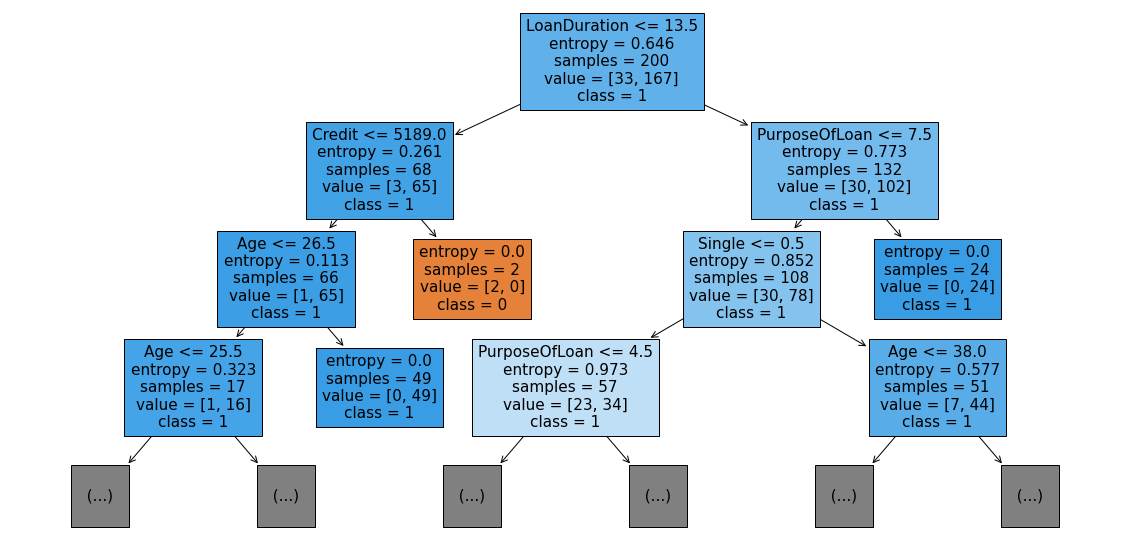

In [54]:
# Plot the structure of the decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, filled=True, feature_names=["Sex","Single","Unemployed","Age","Credit","LoanDuration","PurposeOfLoan","InstallmentRate","Housing"], class_names=["0", "1"], max_depth=3)
plt.savefig('decision_tree_structure.png')
plt.show()

In [55]:
from sklearn.tree import _tree
# Extract a single instance from the validation set to trace its decision path
instance_index = 0  # Example: first instance in the validation set
single_instance = X_test.iloc[[instance_index]]

# Use the decision_path method to get the path for this instance
decision_path = best_model.decision_path(single_instance)

# Initialize lists to store the path details
feature_names = single_instance.columns

# Function to get decision path details for a specific instance
def get_decision_path_details(model, single_instance, feature_names):
    # Get the decision path for the instance
    decision_path = model.decision_path(single_instance).indices

    # Lists to hold the path details
    decision_features = []
    decision_thresholds = []
    decision_directions = []

    tree_ = model.tree_

    for node_index in decision_path:
        if tree_.feature[node_index] != _tree.TREE_UNDEFINED:  # Ensure it's not a leaf node
            # Feature name and threshold
            feature_name = feature_names[tree_.feature[node_index]]
            threshold = tree_.threshold[node_index]

            # Decision direction
            if single_instance.iloc[0, tree_.feature[node_index]] <= threshold:
                decision = f"<= {threshold:.2f} (True)"
            else:
                decision = f"> {threshold:.2f} (False)"

            # Append to lists
            decision_features.append(feature_name)
            decision_thresholds.append(threshold)
            decision_directions.append(decision)

    # Create a DataFrame for visualization
    decision_path_df = pd.DataFrame({
        'Feature': decision_features,
        'Threshold': decision_thresholds,
        'Decision': decision_directions
    })

    return decision_path_df

# Correctly call the function with the required parameters
decision_path_df = get_decision_path_details(best_model, single_instance, feature_names)
decision_path_df


,Feature,Threshold,Decision
0,LoanDuration,13.5,> 13.50 (False)
1,PurposeOfLoan,7.5,<= 7.50 (True)
2,Single,0.5,> 0.50 (False)
3,Age,38.0,<= 38.00 (True)
4,Credit,12534.5,<= 12534.50 (True)
